In [256]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [257]:
import numpy as np
import pandas as pd

In [258]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [259]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [260]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [261]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect= True)

In [262]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [263]:
# Save references to each table
measurement = base.classes.measurement
t_station = base.classes.station


In [264]:
# Create our session (link) from Python to the DB
session = Session(engine)

insepctor = inspect(engine)

columns_2 = insepctor.get_columns("t_station")
for row in columns_2:
    print (row)

columns = insepctor.get_columns("measurement")
for row in columns:
   print (row)


{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# Exploratory Climate Analysis

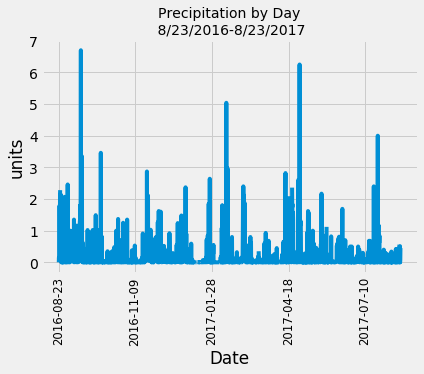

In [265]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database


last12 = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip12 = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last12).order_by(measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip12, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True, )
precip_df.dropna()


precip_df.plot(kind="line", legend= False)
plt.ylabel("units") #no units given outside of gitlab
plt.title(
    "Precipitation by Day\n 8/23/2016-8/23/2017",
    fontweight='medium',
    fontsize='medium')
plt.xticks(
    rotation=90,
    horizontalalignment='center',
    fontweight='light',
    fontsize='small'
)
plt.savefig("Plots/datevprecip.png")



# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [266]:
# Use Pandas to calcualte the summary statistics for the precipitation data

avg_precip = precip_df["Precipitation"].mean()
min_precip = precip_df["Precipitation"].min()
max_precip = precip_df["Precipitation"].max()
sd_precip = precip_df["Precipitation"].std()

print(avg_precip, min_precip, max_precip, sd_precip)

0.17727857496288896 0.0 6.7 0.4611895038877027


In [267]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(t_station.id).count()
stations



9

In [268]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [269]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()



[(54.0, 85.0, 71.66378066378067)]

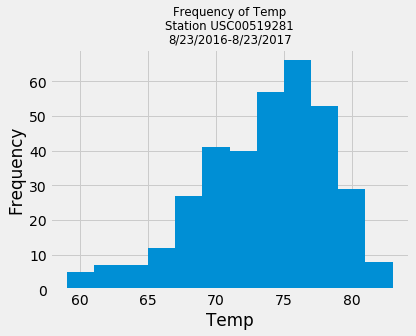

In [270]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


temp_meas = session.query(measurement.station, measurement.tobs).all()
temp_meas = pd.DataFrame(temp_meas)
temp_meas = temp_meas.dropna(how="any")

grouped_temp = temp_meas.groupby("station")["tobs"].count()
grouped_temp = pd.DataFrame(grouped_temp).sort_values(by= ["tobs"], ascending=False)


last12_mostactivestation = session.query(measurement.tobs).filter(measurement.station== 'USC00519281', measurement.date >= last12).all()
tobs = pd.DataFrame(last12_mostactivestation)
tobs.plot.hist(bins=12, legend=None)
plt.tight_layout()
plt.title("Frequency of Temp\nStation USC00519281\n8/23/2016-8/23/2017",
     fontweight='light',
     fontsize='small')
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.savefig("Plots/stationUSC00519281_histo.png")

## Bonus Challenge Assignment

In [271]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [272]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#my dates = 08/23/2014 - 09/03/2014
prior_start = dt.date(2014, 8, 23) - dt.timedelta(days=365)
prior_end = dt.date(2014, 9, 3) - dt.timedelta(days=365)

min_temp, avg_temp, max_temp = calc_temps(prior_start, prior_end)[0]


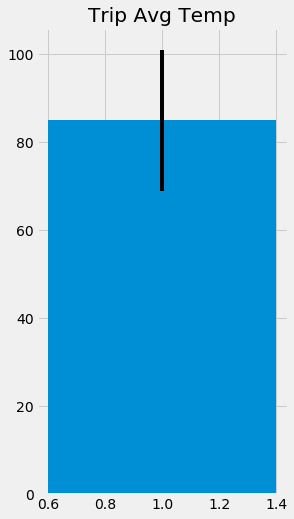

In [273]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = max_temp - min_temp

plot = ax.bar(xpos, max_temp, yerr=yerr)
plt.title("Trip Avg Temp")

plt.savefig("Plots/trip_avg_temp.png")

In [274]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [t_station.station, t_station.name, t_station.latitude, t_station.longitude, t_station.elevation, func.sum(measurement.prcp)]

session.query(*sel).filter(t_station.station == measurement.station).filter(measurement.date >= prior_start, measurement.date <= prior_end).group_by(t_station.station).all()


[('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.41),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.05),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.4),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.05),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.01),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.33),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.37999999999999995)]

In [275]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [276]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

#my dates = 08/23/2014 - 09/03/2014

start_date = '2014-08-23'
end_date = '2014-09-03'

# Use the start and end date to create a range of dates

dates = pd.date_range(start_date, end_date, freq='D')
dates

# Stip off the year and save a list of %m-%d strings

md = dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date

data = []
for x in md:
    data.append(*daily_normals(x))
data


[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0)]

In [277]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_temp_data = pd.DataFrame(data, columns= ["min", "avg", "max"])
daily_temp_data["date"] = dates
daily_temp_data.set_index(["date"], inplace=True)
daily_temp_data

,min,avg,max
date,,,
2014-08-23,67.0,76.692308,87.0
2014-08-24,70.0,75.961538,84.0
2014-08-25,69.0,76.960784,82.0
2014-08-26,71.0,76.568627,84.0
2014-08-27,68.0,76.283019,84.0
2014-08-28,67.0,76.734694,86.0
2014-08-29,70.0,76.235294,85.0
2014-08-30,68.0,76.416667,84.0
2014-08-31,67.0,76.840000,85.0


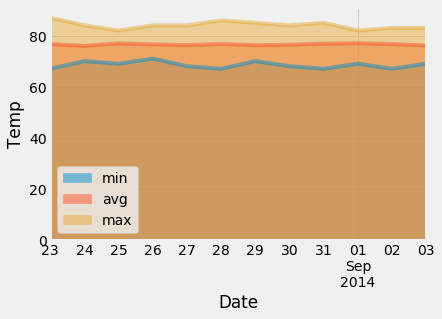

In [278]:
# Plot the daily normals as an area plot with `stacked=False`

daily_temp_data.plot.area(stacked=False)
plt.xlabel("Date")
plt.ylabel("Temp")
plt.savefig("Plots/area_daily_temp.png")